### Load, split and save train, validation and test dataframes
As a result, the train, validation and test dataframes are saved in:
- Train: 1472559 images (0.81%): _data/splitted_dfs_20220528/train_df.json.bz2_
- Val: 181798  images (0.10%): _data/splitted_dfs_20220528/val_df.json.bz2_
- Test: 163618  images (0.09%): _data/splitted_dfs_20220528/test_df.json.bz2_

In [2]:
import pandas as pd
import urllib.parse
import os
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from help_functions import get_y_true

In [3]:
MINIMAL_NR_IMAGES = 1_000

Load naive labels, and pre-process urls.

In [22]:
NAIVE_LABELS_PATH = 'data/commonswiki-20220220-files-naive-labels.json.bz2'
naive_labels = pd.read_json(NAIVE_LABELS_PATH)

# With this encoded url, only 190k images aren't found, while with "url" 790k aren't found
naive_labels['url'] = naive_labels['url'].apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename).encode().decode('unicode-escape'))
naive_labels['can_be_opened'] = naive_labels['url'].apply(lambda url : os.path.isfile('/scratch/WIT_Dataset/images/' + url))
print(f'Total number of files: {naive_labels.shape[0]}.')

naive_labels = naive_labels.loc[naive_labels.can_be_opened == True].reset_index(drop=True)

naive_labels.rename(columns={'new_labels': 'labels'}, inplace=True)
print(f'Total number of files that can be opened: {naive_labels.shape[0]}.')

Total number of files: 2008312.
Total number of files that can be opened: 1817975.


#### Extra cleaning 

When running `model.evaluate()`, it fails with the `PIL.UnidentifiedImageError` exception error. It's mostly images from format .webp, but there are also some .png images. Remove them from the dataset. (Example: `!ls /scratch/WIT_Dataset/images/d/d7/World_Scout_Jamboree_-_Punch_cartoon_-_Project_Gutenberg_eText_16628.png` 

`PIL.Image.open('/scratch/WIT_Dataset/images/d/d7/World_Scout_Jamboree_-_Punch_cartoon_-_Project_Gutenberg_eText_16628.png')`
)

In [1]:
import PIL
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

for index, row in tqdm(naive_labels.iterrows(), total=naive_labels.shape[0]):
    try:
        img = Image.open('/scratch/WIT_Dataset/images/' + row.url)
    except PIL.UnidentifiedImageError:
        print(row.url)
        naive_labels.at[index, 'can_be_opened'] = False
    except Exception as e:
        print(e)
        naive_labels.at[index, 'can_be_opened'] = False

In [35]:
# Only keep the files that can be opened
naive_labels = naive_labels.loc[naive_labels.can_be_opened == True].reset_index(drop=True)
naive_labels.to_json('data/commonswiki-20220531-files-naive-labels.json.bz2', compression='bz2')
print(f'Total number of files that can be opened: {naive_labels.shape[0]}.')

print(naive_labels.shape)
naive_labels.head(2)

Total number of files that can be opened: 1817901.
(1817901, 6)


,id,title,url,categories,labels,can_be_opened
0,74785910,"""Carnevale di Torino"". Felice Cerruti - f.lli ...","1/13/""Carnevale_di_Torino""._Felice_Cerruti_-_f...","[Felice Cerruti Bauduc, Victor Emmanuel II of ...","[Places, Society]",True
1,14890941,"""Escena de playa con figura"".jpg","c/c2/""Escena_de_playa_con_figura"".jpg","[Pedro Lira, People with dogs in art]","[Culture, Entertainment]",True


#### Load dataset that has been cleaned from "UnidentifiedImage error" and only keep .jpg files

In [19]:
naive_labels = pd.read_json('data/commonswiki-20220601-files-naive-labels.json.bz2', compression='bz2')
print(f"{naive_labels.loc[naive_labels.url.str.contains('.jpeg', case=False)].shape[0]} images of type .jpeg")
naive_labels_jpg = naive_labels.loc[naive_labels.url.str.contains('.jpg', case=False)]
print(f'{naive_labels_jpg.shape[0]} images of type .jpg')

18235 images of type .jpeg
1596269 images of type .jpg


Remove labels with less than a certain number of images

Found 1596269 non-validated image filenames belonging to 42 classes.
Removed 887 images that were only labeled as the removed labels. Left with 1.60 M images.


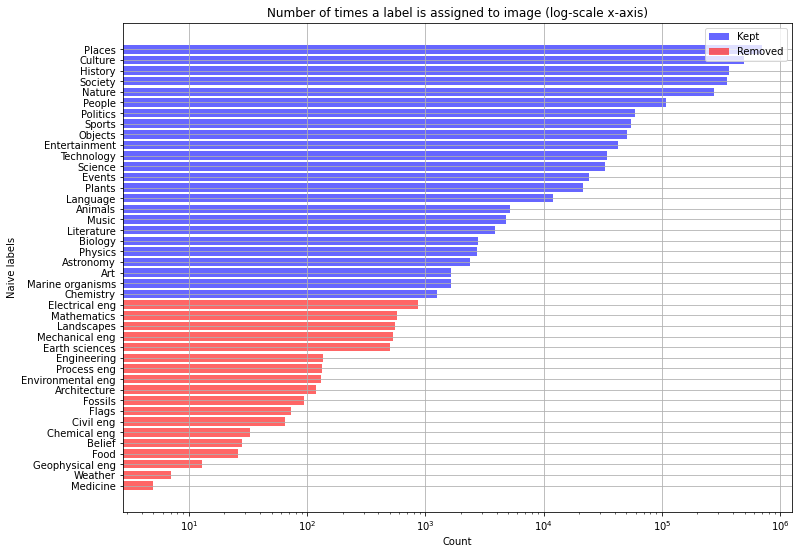

In [20]:
dataframe = naive_labels_jpg.copy()

_generator = ImageDataGenerator() 
_data = _generator.flow_from_dataframe(dataframe=dataframe, 
                                       directory='/scratch/WIT_Dataset/images', 
                                       x_col='url', 
                                       y_col='labels', 
                                       class_mode='categorical', 
                                       validate_filenames=False)

y_true = get_y_true(_data.samples, _data.class_indices, _data.classes)

sorted_indices = np.argsort(np.sum(y_true, axis=0))
sorted_images_per_class = y_true.sum(axis=0)[sorted_indices]

mask_kept = y_true.sum(axis=0)[sorted_indices] > MINIMAL_NR_IMAGES
mask_removed = y_true.sum(axis=0)[sorted_indices] < MINIMAL_NR_IMAGES

_ = plt.figure(figsize=(12, 9))
_ = plt.title('Number of times a label is assigned to image (log-scale x-axis)')

_ = plt.barh(np.array(range(y_true.shape[1]))[mask_kept], sorted_images_per_class[mask_kept], color='blue', alpha=0.6)
_ = plt.barh(np.array(range(y_true.shape[1]))[mask_removed], sorted_images_per_class[mask_removed], color='red', alpha=0.6)

_ = plt.yticks(range(y_true.shape[1]), np.array(list(_data.class_indices.keys()))[sorted_indices])
_ = plt.xscale('log')
_ = plt.xlabel('Count')
_ = plt.ylabel('Naive labels')
_ = plt.grid(True)

plt.legend(['Kept', 'Removed'], loc='upper right')

indices_of_classes_to_remove = np.where(np.sum(y_true, axis=0) < MINIMAL_NR_IMAGES)
classes_to_remove = np.array(list(_data.class_indices.keys()))[indices_of_classes_to_remove]

dataframe['labels'] = dataframe['labels'].apply(lambda labels: [el for el in labels if el not in classes_to_remove])
naive_labels_clean = dataframe[dataframe['labels'].str.len() != 0]
print(f'Removed {dataframe.shape[0] - naive_labels_clean.shape[0]} images that were only labeled as the removed labels. Left with {naive_labels_clean.shape[0]/1e6:.2f} M images.')

Split dataset and save so the same training, validation and test sets are used throughout. Sample 500k images first

In [21]:
# Sample 300k images
naive_labels_clean_samples = naive_labels_clean.sample(n=500_000)

In [22]:
train_df, test_df = train_test_split(naive_labels_clean_samples, test_size=0.05, random_state=17)

print(f'Train set: {train_df.shape[0]} images ({train_df.shape[0] / naive_labels.shape[0]:.2f}%)')
print(f'Test set:  {test_df.shape[0]}  images ({test_df.shape[0] / naive_labels.shape[0]:.2f}%)')

!mkdir data/splitted_dfs_500k_20220602

train_df.to_json('data/splitted_dfs_500k_20220602/train_df.json.bz2', compression='bz2')
test_df.to_json('data/splitted_dfs_500k_20220602/test_df.json.bz2', compression='bz2')

Train set: 475000 images (0.26%)
Test set:  25000  images (0.01%)
